In [24]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import dateutil
from datetime import datetime
from IPython.display import display, HTML
import seaborn as sb
import matplotlib.pyplot as plt

In [25]:
conn = MongoClient("mongodb://localhost:27017/")
print("Connected successfully!!")

Connected successfully!!


In [26]:
db = conn.edfs
print(db)

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'edfs')


In [67]:
def dir_exist_check(db, command, last):
    conn = db.file
    com_list = list(filter(None, command.split('/')))
    # if last is True, we will count last dir into check list, if not we will ignore it(usually for mkdir)
    dr = ''
    if last:
        for i in com_list:
            dr = dr + i + '.'
    else:
        for i in com_list[0:-1]:
            dr = dr + i + '.'
    # get rid of last comma
    dr = dr[0:-1]

    find = conn.find({dr: {"$exists": True}})
    if len(list(find)) > 0:
        return True
    else:
        return False


# check if directory is valid
def command_vali_check(command):
    dir = command.split()[1]
    if len(command.split()) >= 3:
        return False
    elif dir.startswith("/") == False:
        return False
    else:
        return True


# connect with MongoDB
def connect():
    try:
        conn = MongoClient("mongodb://localhost:27017/")
        print("Connected successfully!!")
    except:
        print("Could not connect to MongoDB")

    # database name: edfs
    db = conn.edfs

    # Created or Switched to collection names: file
    # connection = db.file

    return db


# make command transfer to path in mongodb
def path_transfer(cmd):
    com_list = list(filter(None, cmd.split('/')))
    # dr in mongodb format
    dr = ''
    for i in com_list:
        dr = dr + i + '.'

    # get rid of last dot
    dr = dr[0:-1]

    return dr


# make directory
def mkdir(db, cmd):
    conn = db.file
    dr = path_transfer(cmd)
    # get id of root and then update into the file
    root_id = conn.find_one()["_id"]
    conn.update_one({"_id": root_id}, {"$set": {dr: {}}})
    print("done")


def ls(db, cmd):
    conn = db.file
    dr = path_transfer(cmd)
    root_id = conn.find_one()["_id"]
    all_path_list = conn.find({"_id": root_id}, {dr: 1, "_id": 0})

    # get directory as list, dr: Root.user , dr_list: [Root, user]
    dr_list = list(filter(None, dr.split('.')))
    # transfer from cursor to list and get first index value( is a dictionary)
    all_path = list(all_path_list)[0]
    # eg input: ls /user
    # eg output from ls command: {'Root': {'user': {'ss': {}, 'abc': {}}}}
    output_dit = all_path
    for i in dr_list:
        output_dit = output_dit[i]

    # finally output_dit get into final dict to output
    for i in output_dit:
        print(i)


def cat(db, path):
    conn = db.file
    dr = path_transfer(path)
    root_id = conn.find_one()["_id"]
    all_path_list = conn.find({"_id": root_id}, {dr: 1, "_id": 0})

    dr_list = list(filter(None, dr.split('.')))
    all_path = list(all_path_list)[0]

    output_list = all_path
    for i in dr_list:
        output_list = output_list[i]

    # print
    for i in output_list:
        conn = db[i]
        output = conn.find()
        print(list(output))


def rm(db, cmd):
    conn = db.file
    dr = path_transfer(cmd)
    root_id = conn.find_one()["_id"]
    # db.file.update({"_id": ObjectId("63434c7707d3d5baf84098d0")}, { $unset: {"Root.user": 1}})
    conn.update_one({"_id": root_id}, {"$unset": {dr: 1}})
    print("done")


def put(db, filename, path):
    path = "/Root" + path
    dr = path_transfer(path)

    if filename == "case_id.csv":
        dr = dr + ".case_id"
        partitions = ["case_20",
                      "case_21"]
        df = pd.read_csv("../data/case_id.csv", chunksize=1000)

        # drop existing table to avoid redundancy
        db.case_20.drop()
        db.case_21.drop()

        for trunk in df:
            df_20 = trunk[trunk['db_year'] == 2020]
            df_21 = trunk[trunk['db_year'] == 2021]

            dict_20 = df_20.to_dict("records")
            dict_21 = df_21.to_dict("records")

            # inserting
            if len(dict_20) > 0:
                conn = db.case_20
                conn.insert_many(dict_20)

            if len(dict_21) > 0:
                conn = db.case_21
                conn.insert_many(dict_21)

        print("done")

    elif filename == "collision.csv":
        dr = dr + ".collision"
        partitions = ["coll_20",
                      "coll_21"]

        df = pd.read_csv("../data/collision.csv", chunksize=1000, encoding='latin1')

        # drop existing table to avoid redundancy
        db.coll_20.drop()
        db.coll_21.drop()
        db.coll_22.drop()
        for trunk in df:
            trunk['collision_date'] = pd.to_datetime(trunk.collision_date)
            df_20 = trunk[(trunk['collision_date'] > "2020-1-1") & (trunk['collision_date'] < "2021-1-1")]
            df_21 = trunk[(trunk['collision_date'] > "2021-1-1") & (trunk['collision_date'] < "2022-1-1")]

            dict_20 = df_20.to_dict("records")
            dict_21 = df_21.to_dict("records")

            # inserting

            if len(dict_20) > 0:
                conn = db.coll_20
                conn.insert_many(dict_20)

            if len(dict_21) > 0:
                conn = db.coll_21
                conn.insert_many(dict_21)


        print("done")
    elif filename == "LA_County_COVID_Cases.csv":
        dr = dr + ".LA_County_COVID_Cases"
        partitions = ["covid_20",
                      "covid_21"]

        df = pd.read_csv("../data/LA_County_COVID_Cases.csv", chunksize=1000)
        # drop existing table to avoid redundancy
        db.covid_20.drop()
        db.covid_21.drop()
        db.covid_22.drop()

        for trunk in df:
            trunk['date'] = pd.to_datetime(trunk.date)
            df_20 = trunk[(trunk['date'] > "2020-1-1") & (trunk['date'] < "2021-1-1")]
            df_21 = trunk[(trunk['date'] > "2021-1-1") & (trunk['date'] < "2022-1-1")]

            dict_20 = df_20.to_dict("records")
            dict_21 = df_21.to_dict("records")

            # inserting

            if len(dict_20) > 0:
                conn = db.covid_20
                conn.insert_many(dict_20)

            if len(dict_21) > 0:
                conn = db.covid_21
                conn.insert_many(dict_21)


        print("done")
    elif filename == "LA_Weather.csv":
        dr = dr + ".LA_Weather"

        partitions = ["weather_20",
                      "weather_21"]

        df = pd.read_csv("../data/LA_Weather.csv", chunksize=1000)
        # drop existing table to avoid redundancy
        db.weather_19.drop()
        db.weather_20.drop()
        db.weather_21.drop()
        db.weather_22.drop()

        for trunk in df:
            trunk['datetime'] = pd.to_datetime(trunk.datetime)
            df_20 = trunk[(trunk['datetime'] > "2020-1-1") & (trunk['datetime'] < "2021-1-1")]
            df_21 = trunk[(trunk['datetime'] > "2021-1-1") & (trunk['datetime'] < "2022-1-1")]

            dict_20 = df_20.to_dict("records")
            dict_21 = df_21.to_dict("records")

            # inserting

            if len(dict_20) > 0:
                conn = db.weather_20
                conn.insert_many(dict_20)

            if len(dict_21) > 0:
                conn = db.weather_21
                conn.insert_many(dict_21)


        print("done")
    elif filename == "parties.csv":
        dr = dr + ".parties"
        partitions = ["parties"]

        df = pd.read_csv("../data/parties.csv", chunksize=1000)
        # drop existing table to avoid redundancy
        db.parties.drop()

        for trunk in df:

            dict_p = trunk.to_dict("records")

            # inserting
            if len(dict_p) > 0:
                conn = db.parties
                conn.insert_many(dict_p)

        print("done")
    elif filename == "victims.csv":
        dr = dr + ".victims"
        partitions = ["victims"]

        df = pd.read_csv("../data/victims.csv", chunksize=1000)

        # drop existing table to avoid redundancy
        db.victims.drop()

        for trunk in df:

            dict_v = trunk.to_dict("records")

            # inserting
            if len(dict_v) > 0:
                conn = db.victims
                conn.insert_many(dict_v)

        print("done")
    # insert into the path and indicate the partitions

    conn = db.file

    # get id of root and then update into the file
    root_id = conn.find_one()["_id"]
    conn.update_one({"_id": root_id}, {"$set": {dr: partitions}})

    print("done")


In [92]:
def getPartitionLocations(db, path):
    conn = db.file
    dr = path_transfer(path)
    root_id = conn.find_one()["_id"]
    all_path_list = conn.find({"_id": root_id}, {dr: 1, "_id": 0})

    dr_list = list(filter(None, dr.split('.')))
    all_path = list(all_path_list)[0]

    output_list = all_path
    for i in dr_list:
        output_list = output_list[i]

    return output_list

In [93]:
def readPartition(db, path, partition_number):
    conn = db.file
    dr = path_transfer(path)
    root_id = conn.find_one()["_id"]
    all_path_list = conn.find({"_id": root_id}, {dr: 1, "_id": 0})

    dr_list = list(filter(None, dr.split('.')))
    all_path = list(all_path_list)[0]

    output_list = all_path
    for i in dr_list:
        output_list = output_list[i]
    partition_number -= 1

    conn = db[output_list[partition_number]]
    output = conn.find()
    
    df = pd.DataFrame(list(output))

    return df

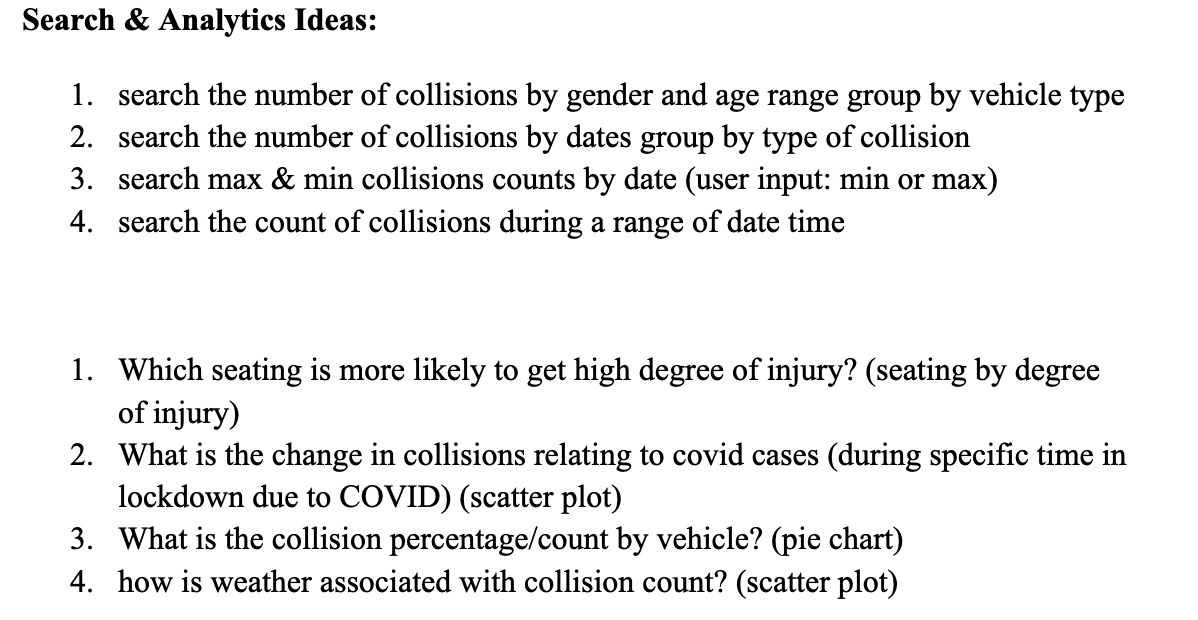

In [133]:
def searchTypeByGenderAge(gender, lage, uage):
    try:
        print('There is only one partition in parties.')
        df = readPartition(db, '/Root/user/dataset/parties', 1)
        
        df = df[(df['party_age'] >= lage) & (df['party_age'] <= uage) & (df['party_sex'] == gender)]
        result = df.groupby(['statewide_vehicle_type'])['id'].count()
        display(result)
        return 'Search Success'
    except:
        return 'InValid Input'

In [134]:
d = searchTypeByGenderAge('female', 20, 30)
d

There is only one partition in parties.


statewide_vehicle_type
bicycle                                  17
emergency vehicle                        20
motorcycle or scooter                    20
other bus                                 6
other vehicle                             3
passenger car                          3428
passenger car with trailer                3
pedestrian                               53
pickup or panel truck                    64
pickup or panel truck with trailer        1
schoolbus                                 3
truck or truck tractor with trailer       2
Name: id, dtype: int64

'Search Success'

In [135]:
def searchColTypeByDates(date):
    try:
        l = getPartitionLocations(db, '/Root/user/dataset/collision')
        print('There are ' + str(len(l)) + ' partitions in collision dataset.')
        result = ''
        for i in range(len(l)):
            df = readPartition(db, '/Root/user/dataset/collision', i+1)
            df = df[df['collision_date'] == date]
            if df.empty:
                print('Partition' + str(i + 1) + ': Empty')
            else:
                result = df.groupby(['type_of_collision'])['case_id'].count()
                print('Partition' + str(i + 1) + ':')
                display(result)

        return 'Search Success!'
    except:
        return 'Invalid Input'
                              

In [136]:
searchColTypeByDates('2020-01-16')

There are 2 partitions in collision dataset.
Partition1:


type_of_collision
broadside     10
hit object     5
other          1
pedestrian     1
rear end      27
sideswipe     10
Name: case_id, dtype: int64

Partition2: Empty


'Search Success!'

In [159]:
def SearchMaxMinCollision(choice):
    try:
        
        l = getPartitionLocations(db, '/Root/user/dataset/collision')
        print('There are ' + str(len(l)) + ' partitions in collision dataset.')

        result = ''
        result_list = []
        for i in range(len(l)):
            df = readPartition(db, '/Root/user/dataset/collision', i+1)
            result = df.groupby(['collision_date'])['case_id'].count().to_frame(name = 'count').reset_index()
            if choice == 'min':
                result = result.sort_values(['count']).head(1)
                result = result.values.tolist()[0]
                result_list.append(result)
                print('Partition' + str(i + 1) + ':')
                print('The ' + choice + ' collision count is ' + str(result[1]) + ' cases on ' + str(result[0])[:10])
            elif choice == 'max':
                result = result.sort_values(['count'], ascending = False).head(1)
                result = result.values.tolist()[0]
                result_list.append(result)
                print('Partition' + str(i + 1) + ':')
                print('The ' + choice + ' collision count is ' + str(result[1]) + ' cases on ' + str(result[0])[:10])
        if choice == 'min':
            if result_list[0][1] <= result_list[1][1]:
                print('The overall ' + choice + ' collision count is ' + str(result_list[0][1]) + ' cases on ' + str(result_list[0][0])[:10])
            elif result_list[0][1] > result_list[1][1]:
                print('The overall ' + choice + ' collision count is ' + str(result_list[1][1]) + ' cases on ' + str(result_list[1][0])[:10])
        elif choice == 'max':
            if result_list[0][1] <= result_list[1][1]:
                print('The overall ' + choice + ' collision count is ' + str(result_list[1][1]) + ' cases on ' + str(result_list[1][0])[:10])
            elif result_list[0][1] > result_list[1][1]:
                print('The overall ' + choice + ' collision count is ' + str(result_list[0][1]) + ' cases on ' + str(result_list[0][0])[:10])
        else:
            return 'Invalid Input'
        
        return 'Search Success!'
    except:
        return 'invalid input'


In [161]:
SearchMaxMinCollision('max')

There are 2 partitions in collision dataset.
Partition1:
The max collision count is 72 cases on 2020-03-12
Partition2:
The max collision count is 57 cases on 2021-02-05
The overall max collision count is 72 cases on 2020-03-12


'Search Success!'

In [169]:
def SearchCollisionInRange(ldate, udate):
    try:
        l = getPartitionLocations(db, '/Root/user/dataset/collision')
        print('There are ' + str(len(l)) + ' partitions in collision dataset.')
        
        sum = 0
        for i in range(len(l)):
            df = readPartition(db, '/Root/user/dataset/collision', i+1)
            df = df[(df['collision_date'] >= ldate) & (df['collision_date'] <= udate)]
            result = df.shape[0]
            sum = sum + result
            print('Partition' + str(i) + ': ' + str(result))
            
        print('Total:', sum)
        return 'Search Success!'
    except:
        return 'invalid input'


In [170]:
SearchCollisionInRange('2020-10-03', '2021-03-03')

There are 2 partitions in collision dataset.
Partition0: 3792
Partition1: 2143
Total: 5935


'Search Success!'

In [175]:
def SeatingByDegree():
    print('There is only one partition in victims.')
    df = readPartition(db, '/Root/user/dataset/victims', 1)
    result = df.groupby(['victim_seating_position', 'victim_degree_of_injury'])['_id'].count()
    display(result)

In [176]:
SeatingByDegree()

There is only one partition in victims.


victim_seating_position        victim_degree_of_injury
driver                         complaint of pain          3036
                               killed                       59
                               no injury                    65
                               other visible injury       1040
                               possible injury            2002
                                                          ... 
rear occupant of truck or van  possible injury               8
station wagon rear             complaint of pain             6
                               no injury                    26
                               possible injury               6
                               suspected minor injury        4
Name: _id, Length: 70, dtype: int64

In [191]:
def ChanegeWithCovid():
    
    l1 = getPartitionLocations(db, '/Root/user/dataset/collision')
    frames = []
    for i in range(len(l1)):
        df = readPartition(db, '/Root/user/dataset/collision', i+1)
        frames.append(df)
    df_coll = pd.concat(frames)
    df_coll = df.groupby(['collision_date'])['case_id'].count().to_frame(name = 'count').reset_index()
    df_coll = df_coll[['collision_date', 'count']]
    
    l2 = getPartitionLocations(db, '/Root/user/dataset/LA_County_COVID_Cases')
    frames = []
    for i in range(len(l2)):
        df = readPartition(db, '/Root/user/dataset/LA_County_COVID_Cases', i+1)
        frames.append(df)
    df_covid = pd.concat(frames)
    df_covid = df_covid[['date', 'cases']]
    df_covid = df_covid.sort_values('date')
    df_covid['new_cases'] = df_covid.cases.diff()
    df_covid.at[0, 'new_cases'] = 1465
    
    
    df_inner = pd.merge(df_coll, df_covid, left_on = 'collision_date', right_on = 'date', how='inner')
    

    plt.figure(figsize = (3, 3))
    plt.scatter(df_inner['count'], df_inner['new_cases'])
    plt.title('Collision Cases vs Covid cases')
    plt.xlabel('Daily Collision Cases')
    plt.ylabel('Daily Covid Cases')
    plt.show()
    
    print('Correlation Coefficient:', df_inner[['count', 'new_cases']].corr())
    print('The collision cases are not highly correlated with the new covid cases.')
    

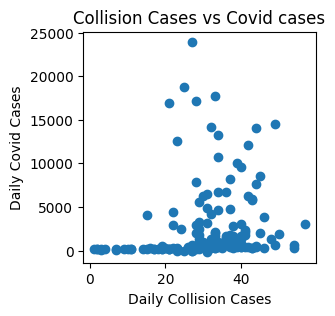

Correlation Coefficient:              count  new_cases
count      1.00000    0.15533
new_cases  0.15533    1.00000
The collision cases are not highly correlated with the new covid cases.


In [192]:
ChanegeWithCovid()

In [209]:
def CollisionByVehicle():
    df = readPartition(db, '/Root/user/dataset/parties', 1)
    df = df.groupby(['statewide_vehicle_type'])['case_id'].count().to_frame(name = 'count').reset_index()

    df = df.sort_values('count', ascending = False)
    

    fig = plt.figure(figsize = (4, 4))
    ax = fig.add_subplot(111)
    ax.pie(df['count'], labels = df['statewide_vehicle_type'], textprops = dict(color='w'))
    ax.legend(df['statewide_vehicle_type'], title="Vehicle Type", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title('The Distribution of Vehicle Type During Collisions', fontsize = 9)
    plt.show()


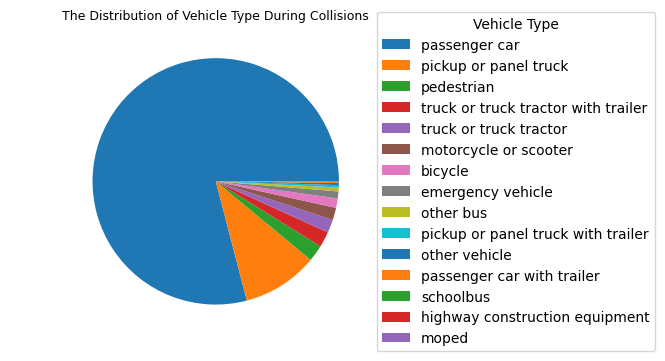

In [210]:
CollisionByVehicle()

In [213]:
def RelationWithVisibility():
    l1 = getPartitionLocations(db, '/Root/user/dataset/collision')
    frames = []
    for i in range(len(l1)):
        df = readPartition(db, '/Root/user/dataset/collision', i+1)
        frames.append(df)
    df_coll = pd.concat(frames)
    df_coll = df.groupby(['collision_date'])['case_id'].count().to_frame(name = 'count').reset_index()
    df_coll = df_coll[['collision_date', 'count']]
    
    l2 = getPartitionLocations(db, '/Root/user/dataset/LA_Weather')
    frames = []
    for i in range(len(l2)):
        df = readPartition(db, '/Root/user/dataset/LA_Weather', i+1)
        frames.append(df)
    df_weather = pd.concat(frames)
    df_weather = df_weather[['datetime', 'visibility']]
    

    df_inner = pd.merge(df_coll, df_weather, left_on = 'collision_date', right_on = 'datetime', how='inner')
    
    plt.figure(figsize = (3, 3))
    plt.scatter(df_inner['count'], df_inner['visibility'])
    plt.title('Collision Cases vs Visibility')
    plt.xlabel('Daily Collision Cases')
    plt.ylabel('Daily Weather Visibility')
    plt.show()
    
    print('Correlation Coefficient:', df_inner[['count', 'visibility']].corr())
    print('Surprisingly, The collision cases are not highly correlated with the new covid cases.')
    

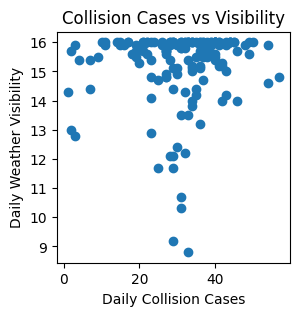

Correlation Coefficient:                count  visibility
count       1.000000    0.088757
visibility  0.088757    1.000000
Surprisingly, The collision cases are not highly correlated with the new covid cases.


In [214]:
RelationWithVisibility()